In [51]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [45]:
normal_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # normalize from [0,1] to [-1,1]
])

In [46]:
#read dataset, it combine all three folders into one
dataset = datasets.ImageFolder(root="F:/dataset/potato_disease", 
                               transform=normal_transform)

In [4]:
#we must split into 3 separate classes, 
#because if we just randomly split into train/dev/test, they might be very skewed
early_blight = []
healthy = []
late_blight = []
for ex in range(len(dataset)):
    if dataset[ex][1] == 0:
        early_blight.append(dataset[ex])
    elif dataset[ex][1] ==1: 
        healthy.append(dataset[ex])
    else:
        late_blight.append(dataset[ex])
len(early_blight), len(healthy), len(late_blight)

(1000, 152, 1000)

In [9]:
#custom datasets that are the same as above (list) but with extra Pytorch features
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x, y = self.data[idx]
        #change label to tensor too
        y = torch.tensor(y, dtype=torch.long)
        return x, y

In [10]:
#change healthy, early_blight, late_blight to dataset, then split into train and test set, and then concat all three of them
## -> finally turn them into train_dataloader, test_dataloader
healthy_data = CustomDataset(healthy)
train_size = int(0.8*len(healthy_data))
test_size = len(healthy_data) - train_size
healthy_train, healthy_test = random_split(healthy_data, [train_size, test_size])

early_data = CustomDataset(early_blight)
train_size = int(0.8*len(early_data))
test_size = len(early_data) - train_size
early_train, early_test = random_split(early_data, [train_size, test_size])

late_data = CustomDataset(late_blight)
train_size = int(0.8*len(late_data))
test_size = len(late_data) - train_size
late_train, late_test = random_split(late_data, [train_size, test_size])

#concat them using ConcatDataset
train_data = torch.utils.data.ConcatDataset([healthy_train, early_train, late_train])
test_data = torch.utils.data.ConcatDataset([healthy_test, early_test, late_test])

#turn them into DataLoader
train_dataloader = DataLoader(train_data, batch_size = 32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size = 32, shuffle=False)

In [11]:
for images, labels in train_dataloader:
    print(images.shape)   # e.g. [32, 3, 224, 224]
    print(labels.shape)   # e.g. [32]
    break 

torch.Size([32, 3, 256, 256])
torch.Size([32])


In [37]:
#define CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size = 3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(63*63*32, 128)
        self.fc2 = nn.Linear(128, 3)
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 63*63*32)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [38]:
#setup device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [47]:
#create an instance
model = CNN().to(device)

#setup metrics, loss, optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = 1e-3)

In [48]:
#deefine train function
def train_step(model, train_dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        
        logits = model(images)
        loss = loss_fn(logits, labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss/len(train_dataloader)

In [49]:
#define evaluate step 
def evaluate_model(model, test_dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.inference_mode():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            pred = torch.argmax(logits, dim=1)
            # print(pred[:6])
            total += labels.size(0)
            correct += (pred == labels).sum().item()
        return 100*(correct/total)

In [50]:
#train and test
torch.manual_seed(42)
epochs = 10

for epoch in range(epochs):
    loss = train_step(model, train_dataloader, loss_fn, optimizer, device)
    print(f"Epoch: {epoch} | loss: {loss}")
    acc = evaluate_model(model, test_dataloader, device)
    print(f"Accuracy: {acc}%")


Epoch: 0 | loss: 0.8150042102292732
Accuracy: 87.00696055684455%
Epoch: 1 | loss: 0.36427602392655833
Accuracy: 89.55916473317865%
Epoch: 2 | loss: 0.20096876279071527
Accuracy: 94.19953596287704%
Epoch: 3 | loss: 0.12884131605150523
Accuracy: 94.66357308584686%
Epoch: 4 | loss: 0.07326155245580056
Accuracy: 94.89559164733178%
Epoch: 5 | loss: 0.047299485093120625
Accuracy: 97.21577726218096%
Epoch: 6 | loss: 0.05175525462254882
Accuracy: 93.50348027842227%
Epoch: 7 | loss: 0.05855747524441944
Accuracy: 95.35962877030161%
Epoch: 8 | loss: 0.0557969013893011
Accuracy: 96.75174013921114%
Epoch: 9 | loss: 0.021851358165602304
Accuracy: 97.4477958236659%


it can be way much better if we use data augmentation,... but for practice, this is good enough

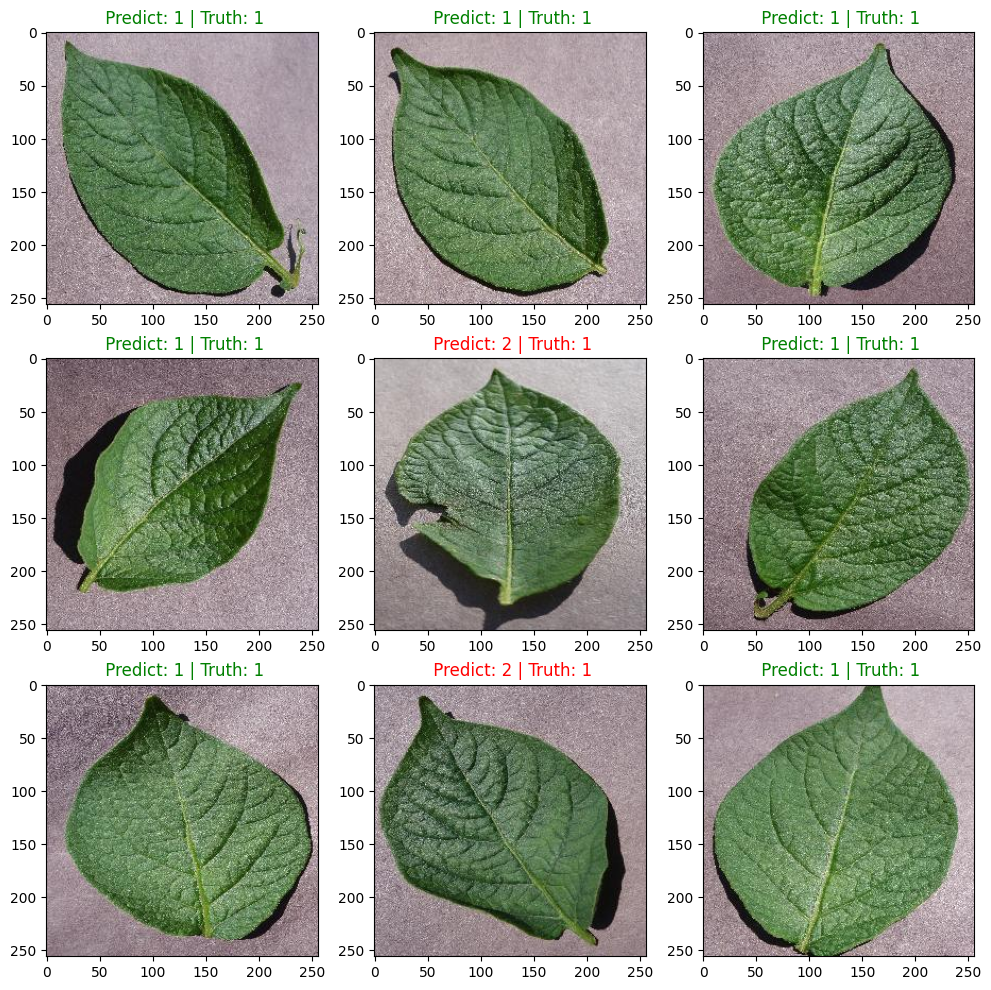

In [81]:
#predict for visualization
images, labels = next(iter(test_dataloader))
plt.figure(figsize=(12,12))
nrows=3
ncols=3
for i in range(10,19):
    plt.subplot(nrows, ncols, i-9)
    #permute works, it reorders the channels. not view
    plt.imshow(images[i-9].permute(1,2,0))
    
    pred = model(images[i-9].to(device).unsqueeze(0)).argmax(dim=1)[0]

    if pred == labels[i-9]:
        plt.title(f" Predict: {pred} | Truth: {labels[i-9]}", c='green')
    else:
        plt.title(f" Predict: {pred} | Truth: {labels[i-9]}", c='red')

we can use confusion matrix also